### Keras & TensorFlow to Predict Market Movements and Backtesting

In [174]:
# make the necessary imports 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import yfinance as yf
import warnings
import datetime
import pyfolio as pf
import backtrader as bt
from backtrader.feeds import PandasData
import warnings
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Dense, Dropout
from keras.models import Sequential
from talib import RSI, BBANDS, MACD

# set the style and ignore warnings
plt.style.use('seaborn-colorblind')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [175]:
# this is to display images in notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Data Gathering

In [176]:
# ticker and the start and end dates for testing
ticker =  '^NSEI' # Nifty 50 benchmark
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2020, 8, 31)

In [177]:
# download ticker stock price from yahoo finance
stock =  yf.download(ticker, progress=True, actions=True,start=start, end=end)['Adj Close']
stock = pd.DataFrame(stock)
stock.rename(columns = {'Adj Close':'close'}, inplace=True)
stock.head(2)

[*********************100%%**********************]  1 of 1 completed


,close
Date,
2010-01-04,5232.200195
2010-01-05,5277.899902


In [178]:
# calculate daily log returns and market direction
stock['returns'] = np.log(stock / stock.shift(1))
stock.dropna(inplace=True)
stock['direction'] = np.sign(stock['returns']).astype(int)
stock.head(3)

,close,returns,direction
Date,,,
2010-01-05,5277.899902,0.008696,1
2010-01-06,5281.799805,0.000739,1
2010-01-07,5263.100098,-0.003547,-1


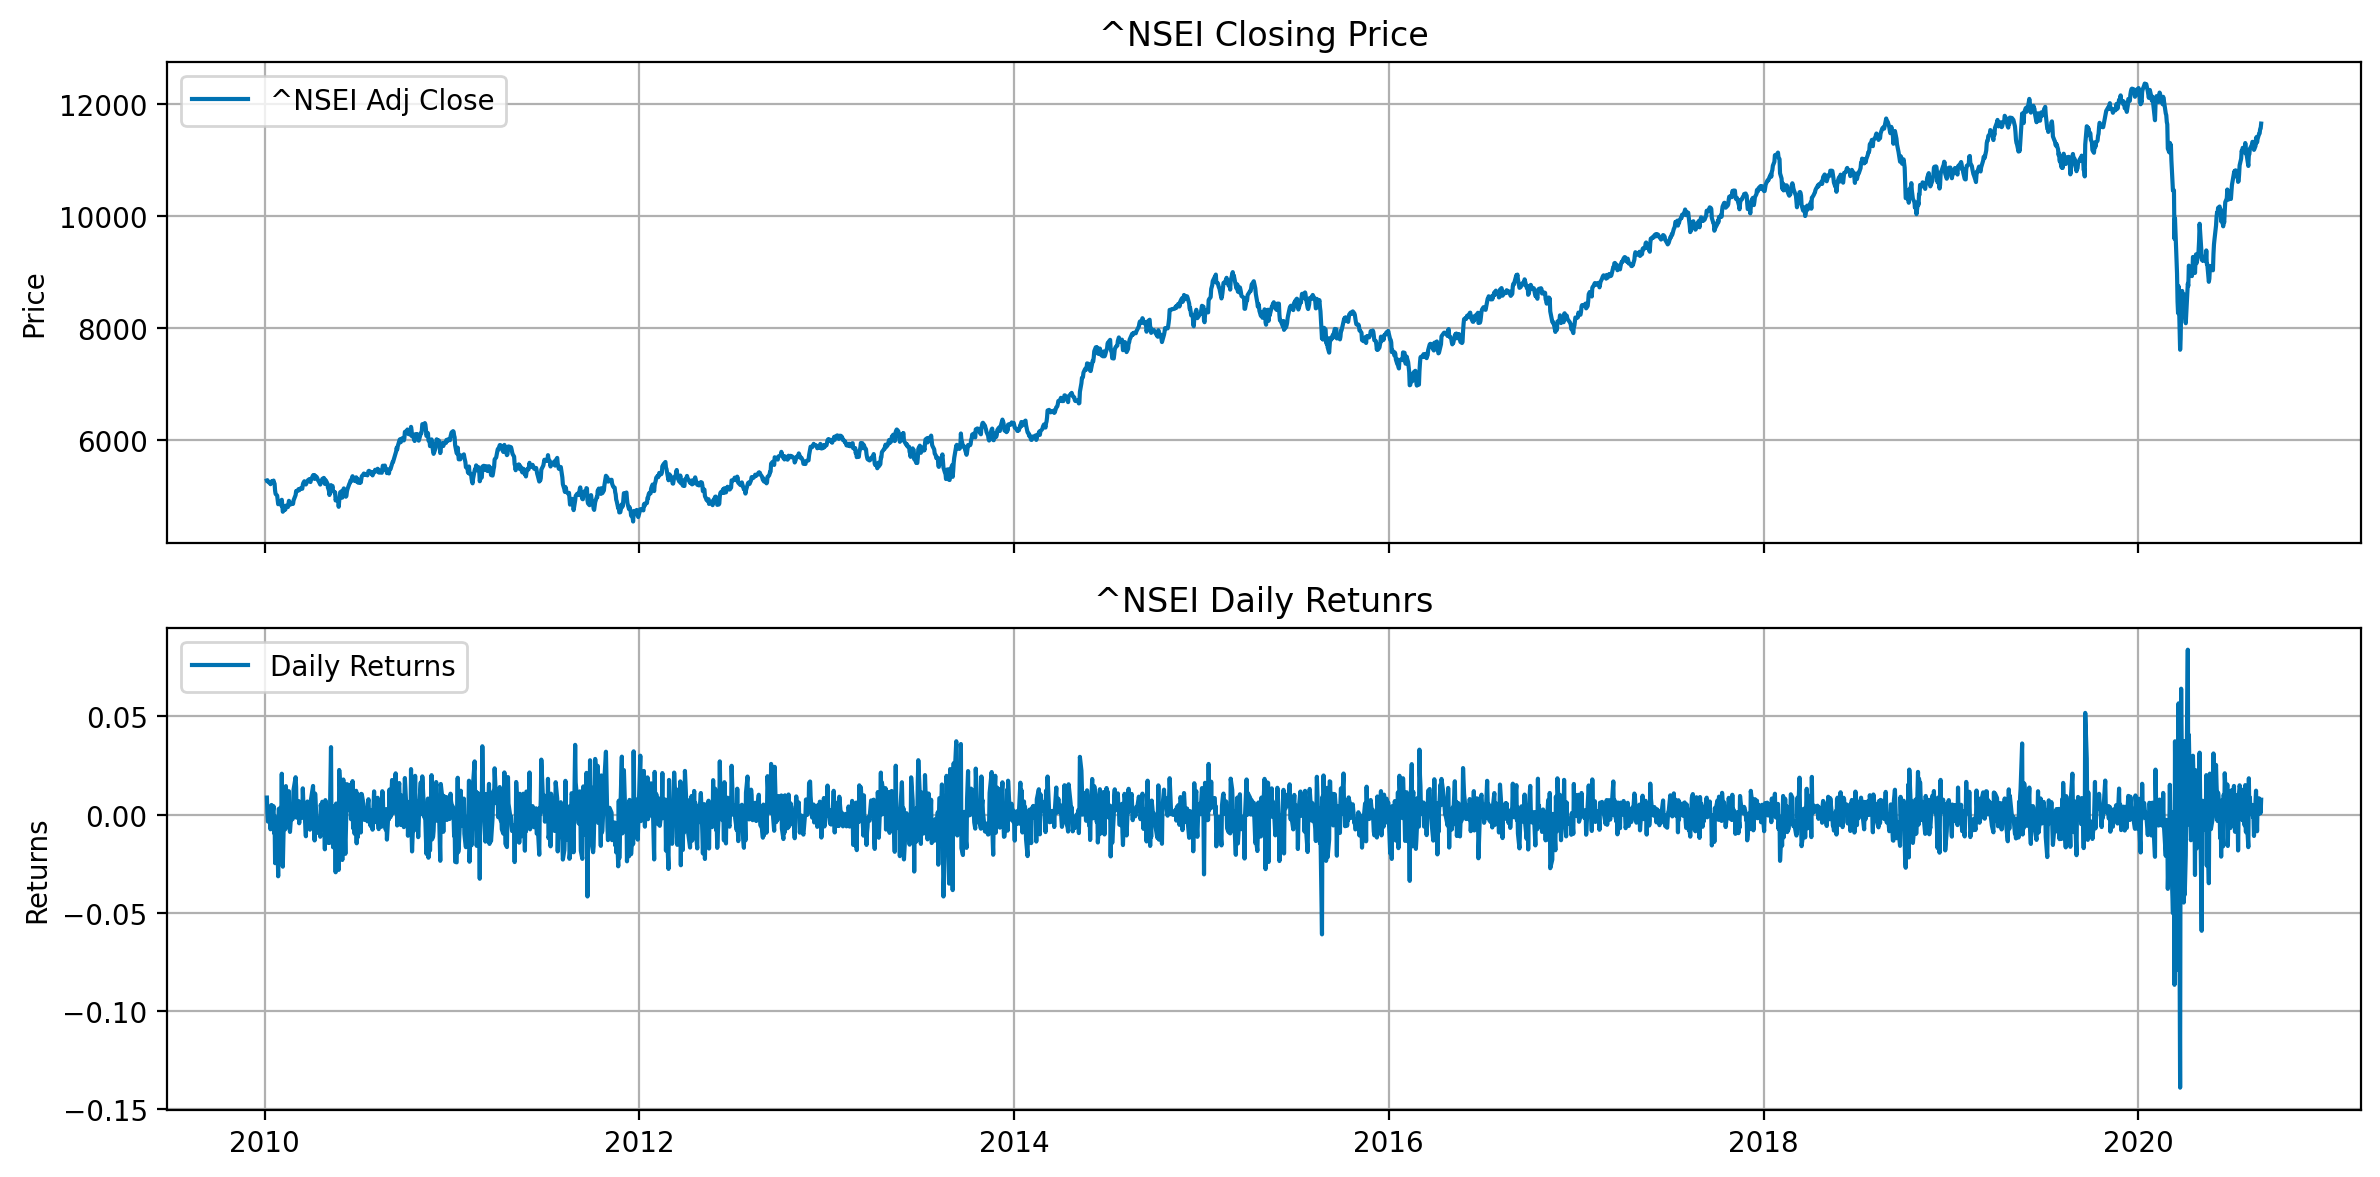

In [179]:
# visualize the closing price and daily returns
fig, ax = plt.subplots(2, 1, sharex=True, figsize = (12,6))
ax[0].plot(stock.close, label = f'{ticker} Adj Close')
ax[0].set(title = f'{ticker} Closing Price', ylabel = 'Price')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(stock['returns'], label = 'Daily Returns')
ax[1].set(title = f'{ticker} Daily Retunrs', ylabel = 'Returns')
ax[1].grid(True)
plt.legend()

plt.tight_layout();
plt.savefig('images/chart1', dpi=300)

### Feature Engineering

In [180]:
# define the number of lags
lags = [1, 2, 3, 4, 5]

In [181]:
# compute lagged log returns
cols = []
for lag in lags:
    col = f'rtn_lag{lag}'
    stock[col] = stock['returns'].shift(lag)
    cols.append(col)
stock.head(2)

,close,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5
Date,,,,,,,,
2010-01-05,5277.899902,0.008696,1,NaN,NaN,NaN,NaN,NaN
2010-01-06,5281.799805,0.000739,1,0.008696,NaN,NaN,NaN,NaN


In [182]:
# RSI - Relative Strenght Index
stock['rsi'] = RSI(stock.close)

# append to feature columns list
cols.append('rsi')
stock.tail(2)

,close,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5,rsi
Date,,,,,,,,,
2020-08-27,11559.250000,0.000835,1,0.006720,0.000506,0.008306,0.005237,-0.008468,68.385929
2020-08-28,11647.599609,0.007614,1,0.000835,0.006720,0.000506,0.008306,0.005237,71.166549


In [183]:
# Compute Bollinger Bands
high, mid, low = BBANDS(stock.close, timeperiod=20)
stock = stock.join(pd.DataFrame({'bb_high': high, 'bb_low': low}, index=stock.index))

# append to feature columns list
cols.append('bb_high')
cols.append('bb_low')

In [184]:
# Compute Moving Average Convergence/ Divergence
stock['macd'] = MACD(stock.close)[0]

# append to feature columns list
cols.append('macd')

In [185]:
# # let's look at the head and tail of our dataframe
# stock.head().append(stock.tail())

### Build and Apply the Model

In [186]:
# len(cols)

In [187]:
# split the dataset in training and test datasets
train, test = train_test_split(stock.dropna(), test_size=0.4, shuffle=False)

# sort the data on date index
train = train.copy().sort_index()
test = test.copy().sort_index()

In [188]:
# # view train dataset
# train.tail()

In [189]:
# # view test dataset
# test.tail()

To know more about keras and TF, please refer to https://keras.io/

In [190]:
# define a function to create the deep neural network model
def create_model():
    np.random.seed(100)
    tf.random.set_seed(100)
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=len(cols)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', #'rmsprop', 
                  metrics=['accuracy'])
    return model

In [191]:
# normalized the training dataset
mu, std = train.mean(), train.std()
train_ = (train - mu) / mu.std()

In [192]:
# create the model
model = create_model()

In [193]:
# map market direction of (1,-1) to (1,0)
train['direction_'] = np.where(train['direction'] > 0, 1, 0)

In [194]:
# cols

In [195]:
# train_.head()

In [196]:
%%time
# fit the model for training dataset
r = model.fit(train_[cols], train['direction_'], epochs=50, verbose=False)

CPU times: user 1.88 s, sys: 446 ms, total: 2.33 s
Wall time: 1.66 s


In [197]:
# normalized the test dataset
mu, std = test.mean(), test.std()
test_ = (test - mu) / std

In [198]:
# map market direction of (1,-1) to (1,0)
test['direction_'] = np.where(test['direction'] > 0, 1, 0)

In [199]:
# evaluate the model with test dataset
model.evaluate(test_[cols], test['direction_'])

33/33 [==============================] - 0s 551us/step - loss: 29.1470 - accuracy: 0.6456


[29.146961212158203, 0.6456310749053955]

In [200]:
# predict the direction and map it (1,0)
pred = np.where(model.predict(test_[cols]) > 0.5, 1, 0) 
pred[:10].flatten()

33/33 [==============================] - 0s 446us/step


array([1, 1, 1, 1, 0, 0, 1, 1, 1, 1])

In [201]:
# based on prediction calculate the position for strategy
test['position_strategy'] = np.where(pred > 0, 1, -1)

In [202]:
# calculate daily returns for the strategy
test['strategy_return'] = test['position_strategy'] * test['returns']

In [203]:
# test.head()

In [204]:
# calculate total return and std. deviation of each strategy
print('\nTotal Returns:')
print(test[['returns', 'strategy_return']].sum().apply(np.exp))
print('\nAnnual Volatility:')
print(test[['returns', 'strategy_return']].std() * 252 ** 0.5)


Total Returns:
returns             1.425620
strategy_return    19.507025
dtype: float64

Annual Volatility:
returns            0.186696
strategy_return    0.181071
dtype: float64


In [205]:
# number of trades over time for the strategy
print('Number of trades = ', (test['position_strategy'].diff()!=0).sum())

Number of trades =  179


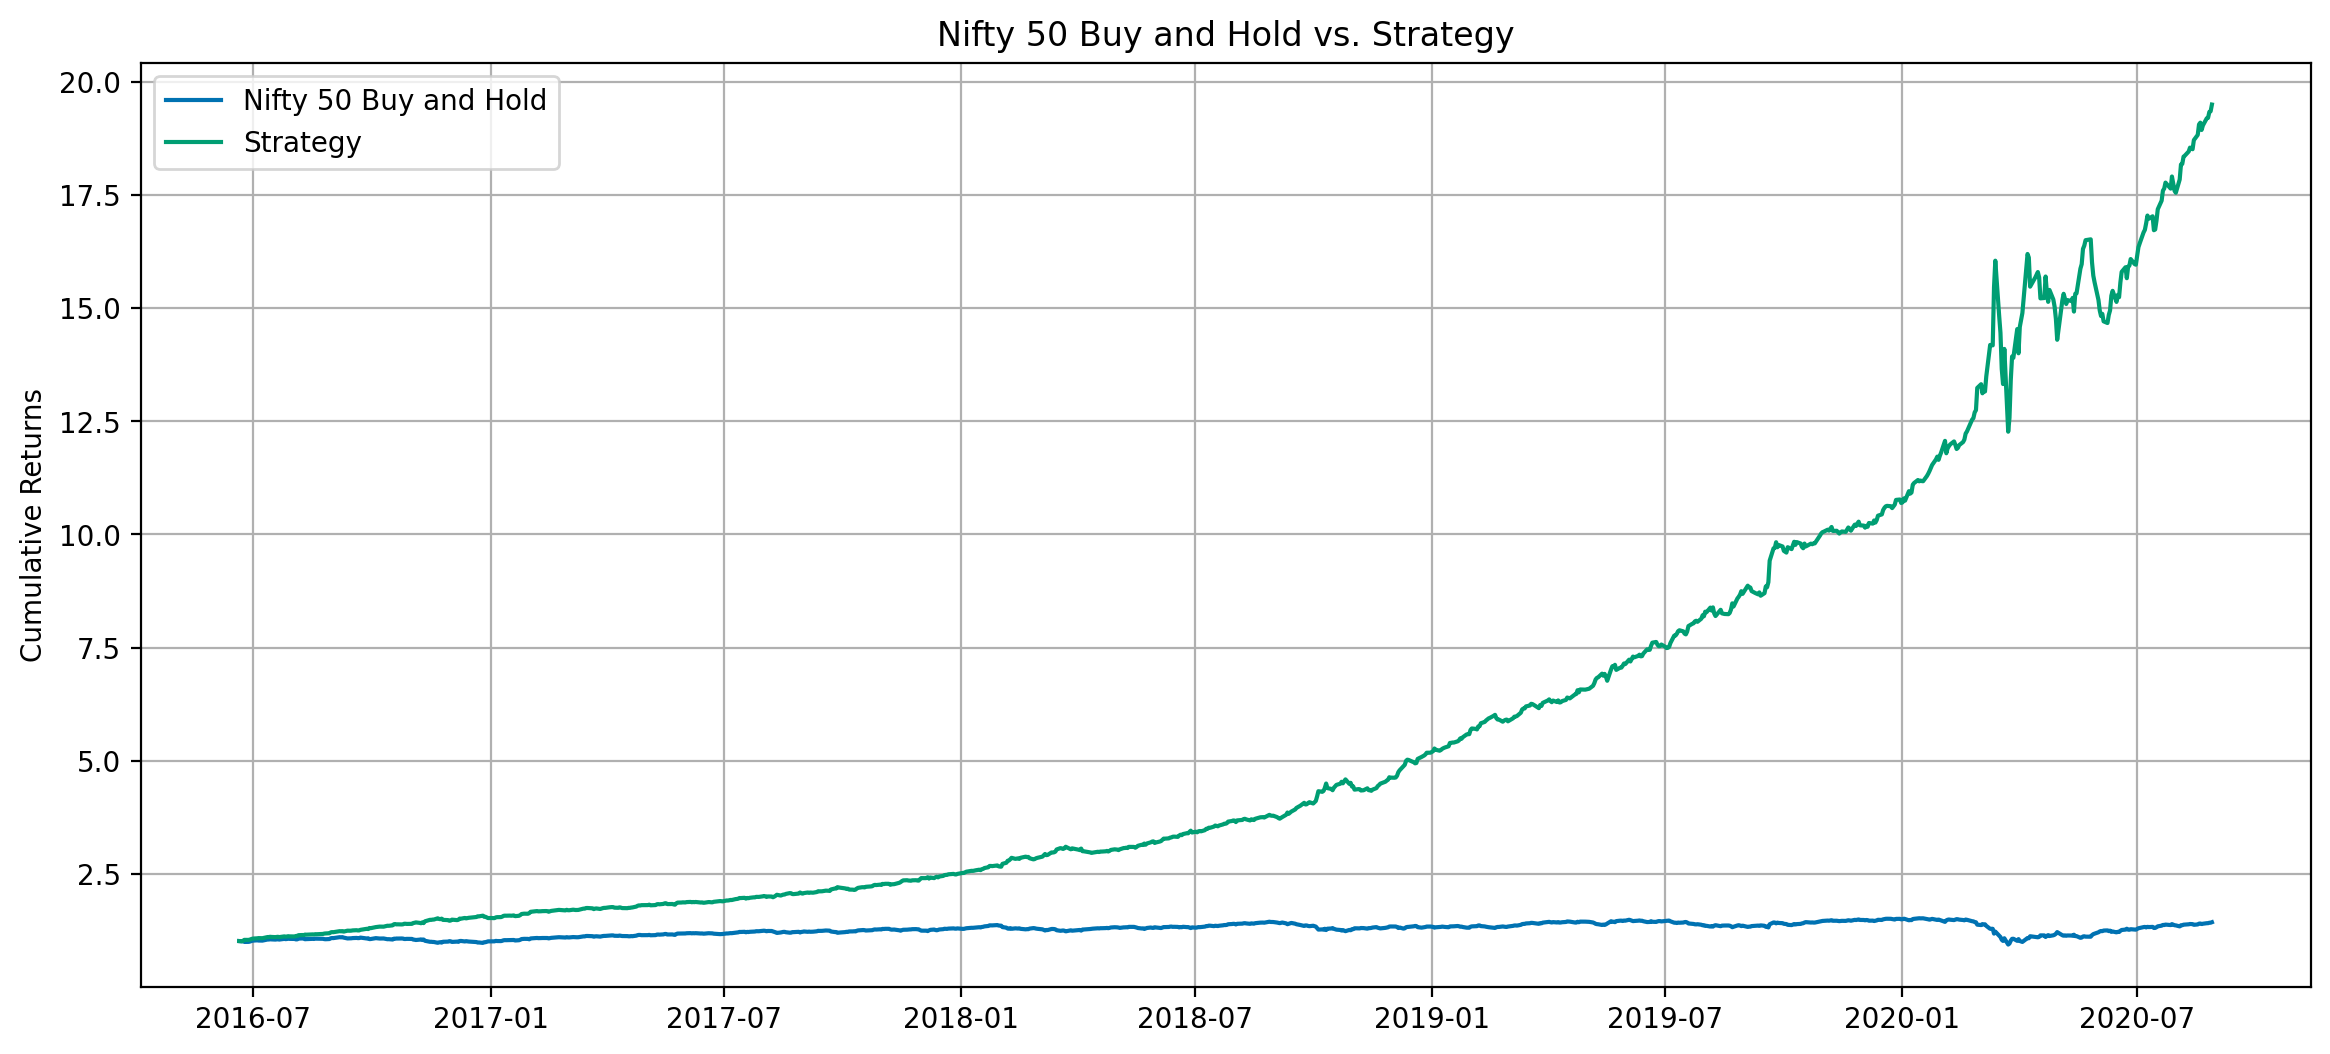

In [206]:
# plot cumulative returns
fig, ax = plt.subplots(1, 1, sharex=True, figsize = (14,6))
ax.plot(test.returns.cumsum().apply(np.exp), label = 'Nifty 50 Buy and Hold')
ax.plot(test.strategy_return.cumsum().apply(np.exp), label = 'Strategy')
ax.set(title = 'Nifty 50 Buy and Hold vs. Strategy', ylabel = 'Cumulative Returns')
ax.grid(True)
ax.legend()
plt.savefig('images/chart2');

### Backtesting using Backtrader

In [207]:
# backtesting start and end dates
start = test.index[0]
end = test.index[-1]
print(start)
print(end)

2016-06-20 00:00:00
2020-08-28 00:00:00


In [208]:
# fetch the daily pricing data from yahoo finance
prices =  yf.download(ticker, progress=True, actions=True, start=start, end=end)
prices.head(2)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
Date,,,,,,,,
2016-06-20,8115.750000,8244.150391,8107.350098,8238.500000,8238.500000,168600,0.0,0.0
2016-06-21,8255.400391,8257.250000,8202.150391,8219.900391,8219.900391,137000,0.0,0.0


In [209]:
# rename the columns as needed for Backtrader
prices.drop(['Close','Dividends','Stock Splits'], inplace=True, axis=1)
prices.rename(columns = {'Open':'open','High':'high','Low':'low','Adj Close':'close','Volume':'volume',
                         }, inplace=True)

In [210]:
prices.head(3)

,open,high,low,close,volume
Date,,,,,
2016-06-20,8115.750000,8244.150391,8107.350098,8238.500000,168600
2016-06-21,8255.400391,8257.250000,8202.150391,8219.900391,137000
2016-06-22,8213.650391,8238.349609,8153.250000,8203.700195,136100


In [211]:
# add the predicted column to prices dataframe. This will be used as signal for buy or sell
predictions = test.strategy_return
predictions = pd.DataFrame(predictions)
predictions.rename(columns = {'strategy_return':'predicted'}, inplace=True)
prices = predictions.join(prices, how='right').dropna()
prices.head(2)

,predicted,open,high,low,close,volume
Date,,,,,,
2016-06-20,0.008325,8115.750000,8244.150391,8107.350098,8238.500000,168600
2016-06-21,-0.002260,8255.400391,8257.250000,8202.150391,8219.900391,137000


In [89]:
prices[['predicted']].sum().apply(np.exp)

predicted    18.198278
dtype: float64

In [90]:
OHLCV = ['open', 'high', 'low', 'close', 'volume']

In [91]:
# class to define the columns we will provide
class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['predicted']

    # create lines
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

Strategy: 
1.	Buy when the predicted value is +1 and sell (only if stock is in possession) when the predicted value is -1.
2.	All-in strategy—when creating a buy order, buy as many shares as possible.
3.	Short selling is not allowed

In [92]:
# define backtesting strategy class
class MLStrategy(bt.Strategy):
    params = dict(
    )
    
    def __init__(self):
        # keep track of open, close prices and predicted value in the series
        self.data_predicted = self.datas[0].predicted
        self.data_open = self.datas[0].open
        self.data_close = self.datas[0].close
        
        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

    # logging function
    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )

        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

    # We have set cheat_on_open = True.This means that we calculated the signals on day t's close price, 
    # but calculated the number of shares we wanted to buy based on day t+1's open price.
    def next_open(self):
        if not self.position:
            if self.data_predicted > 0:
                # calculate the max number of shares ('all-in')
                size = int(self.broker.getcash() / self.datas[0].open)
                # buy order
#                 self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
                self.buy(size=size)
        else:
            if self.data_predicted < 0:
                # sell order
#                 self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.sell(size=self.position.size)

In [93]:
# instantiate SignalData class
data = SignalData(dataname=prices)

In [94]:
# instantiate Cerebro, add strategy, data, initial cash, commission and pyfolio for performance analysis
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)
cerebro.addstrategy(MLStrategy)
cerebro.adddata(data, name=ticker)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

In [95]:
# run the backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
backtest_result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2016-06-23, BUY EXECUTED --- Price: 8201.15, Cost: 98413.80,Commission: 98.41
2016-06-27, SELL EXECUTED --- Price: 8039.35, Cost: 98413.80,Commission: 96.47
2016-06-27, OPERATION RESULT --- Gross: -1941.60, Net: -2136.49
2016-06-29, BUY EXECUTED --- Price: 8173.10, Cost: 89904.10,Commission: 89.90
2016-07-07, SELL EXECUTED --- Price: 8342.00, Cost: 89904.10,Commission: 91.76
2016-07-07, OPERATION RESULT --- Gross: 1857.90, Net: 1676.23
2016-07-11, BUY EXECUTED --- Price: 8413.35, Cost: 92546.85,Commission: 92.55
2016-07-13, SELL EXECUTED --- Price: 8540.45, Cost: 92546.85,Commission: 93.94
2016-07-13, OPERATION RESULT --- Gross: 1398.11, Net: 1211.61
2016-07-14, BUY EXECUTED --- Price: 8515.75, Cost: 93673.25,Commission: 93.67
2016-07-15, SELL EXECUTED --- Price: 8565.45, Cost: 93673.25,Commission: 94.22
2016-07-15, OPERATION RESULT --- Gross: 546.70, Net: 358.81
2016-07-19, BUY EXECUTED --- Price: 8514.30, Cost: 93657.30,Commission: 93.66
2016-07-21

In [96]:
# Extract inputs for pyfolio
strat = backtest_result[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
returns.name = 'Strategy'
returns.head(10)

index
2016-06-20 00:00:00+00:00    0.000000
2016-06-21 00:00:00+00:00    0.000000
2016-06-22 00:00:00+00:00    0.000000
2016-06-23 00:00:00+00:00    0.007332
2016-06-24 00:00:00+00:00   -0.021663
2016-06-27 00:00:00+00:00   -0.006976
2016-06-28 00:00:00+00:00    0.000000
2016-06-29 00:00:00+00:00    0.002555
2016-06-30 00:00:00+00:00    0.009390
2016-07-01 00:00:00+00:00    0.004509
Name: Strategy, dtype: float64

In [47]:
# get benchmark returns
benchmark_rets= stock['returns']
benchmark_rets.index = benchmark_rets.index.tz_localize('UTC') 
benchmark_rets = benchmark_rets.filter(returns.index)
benchmark_rets.name = 'Nifty-50'
benchmark_rets.head(2)

Date
2016-06-20 00:00:00+00:00    0.008325
2016-06-21 00:00:00+00:00   -0.002260
Name: Nifty-50, dtype: float64

In [48]:
# get performance statistics for strategy
pf.show_perf_stats(returns)

Start date,2016-06-20
End date,2020-08-27
Total months,49
,Backtest
Annual return,-10.0%
Cumulative returns,-35.0%
Annual volatility,14.3%
Sharpe ratio,-0.67
Calmar ratio,-0.19
Stability,0.75
Max drawdown,-51.9%


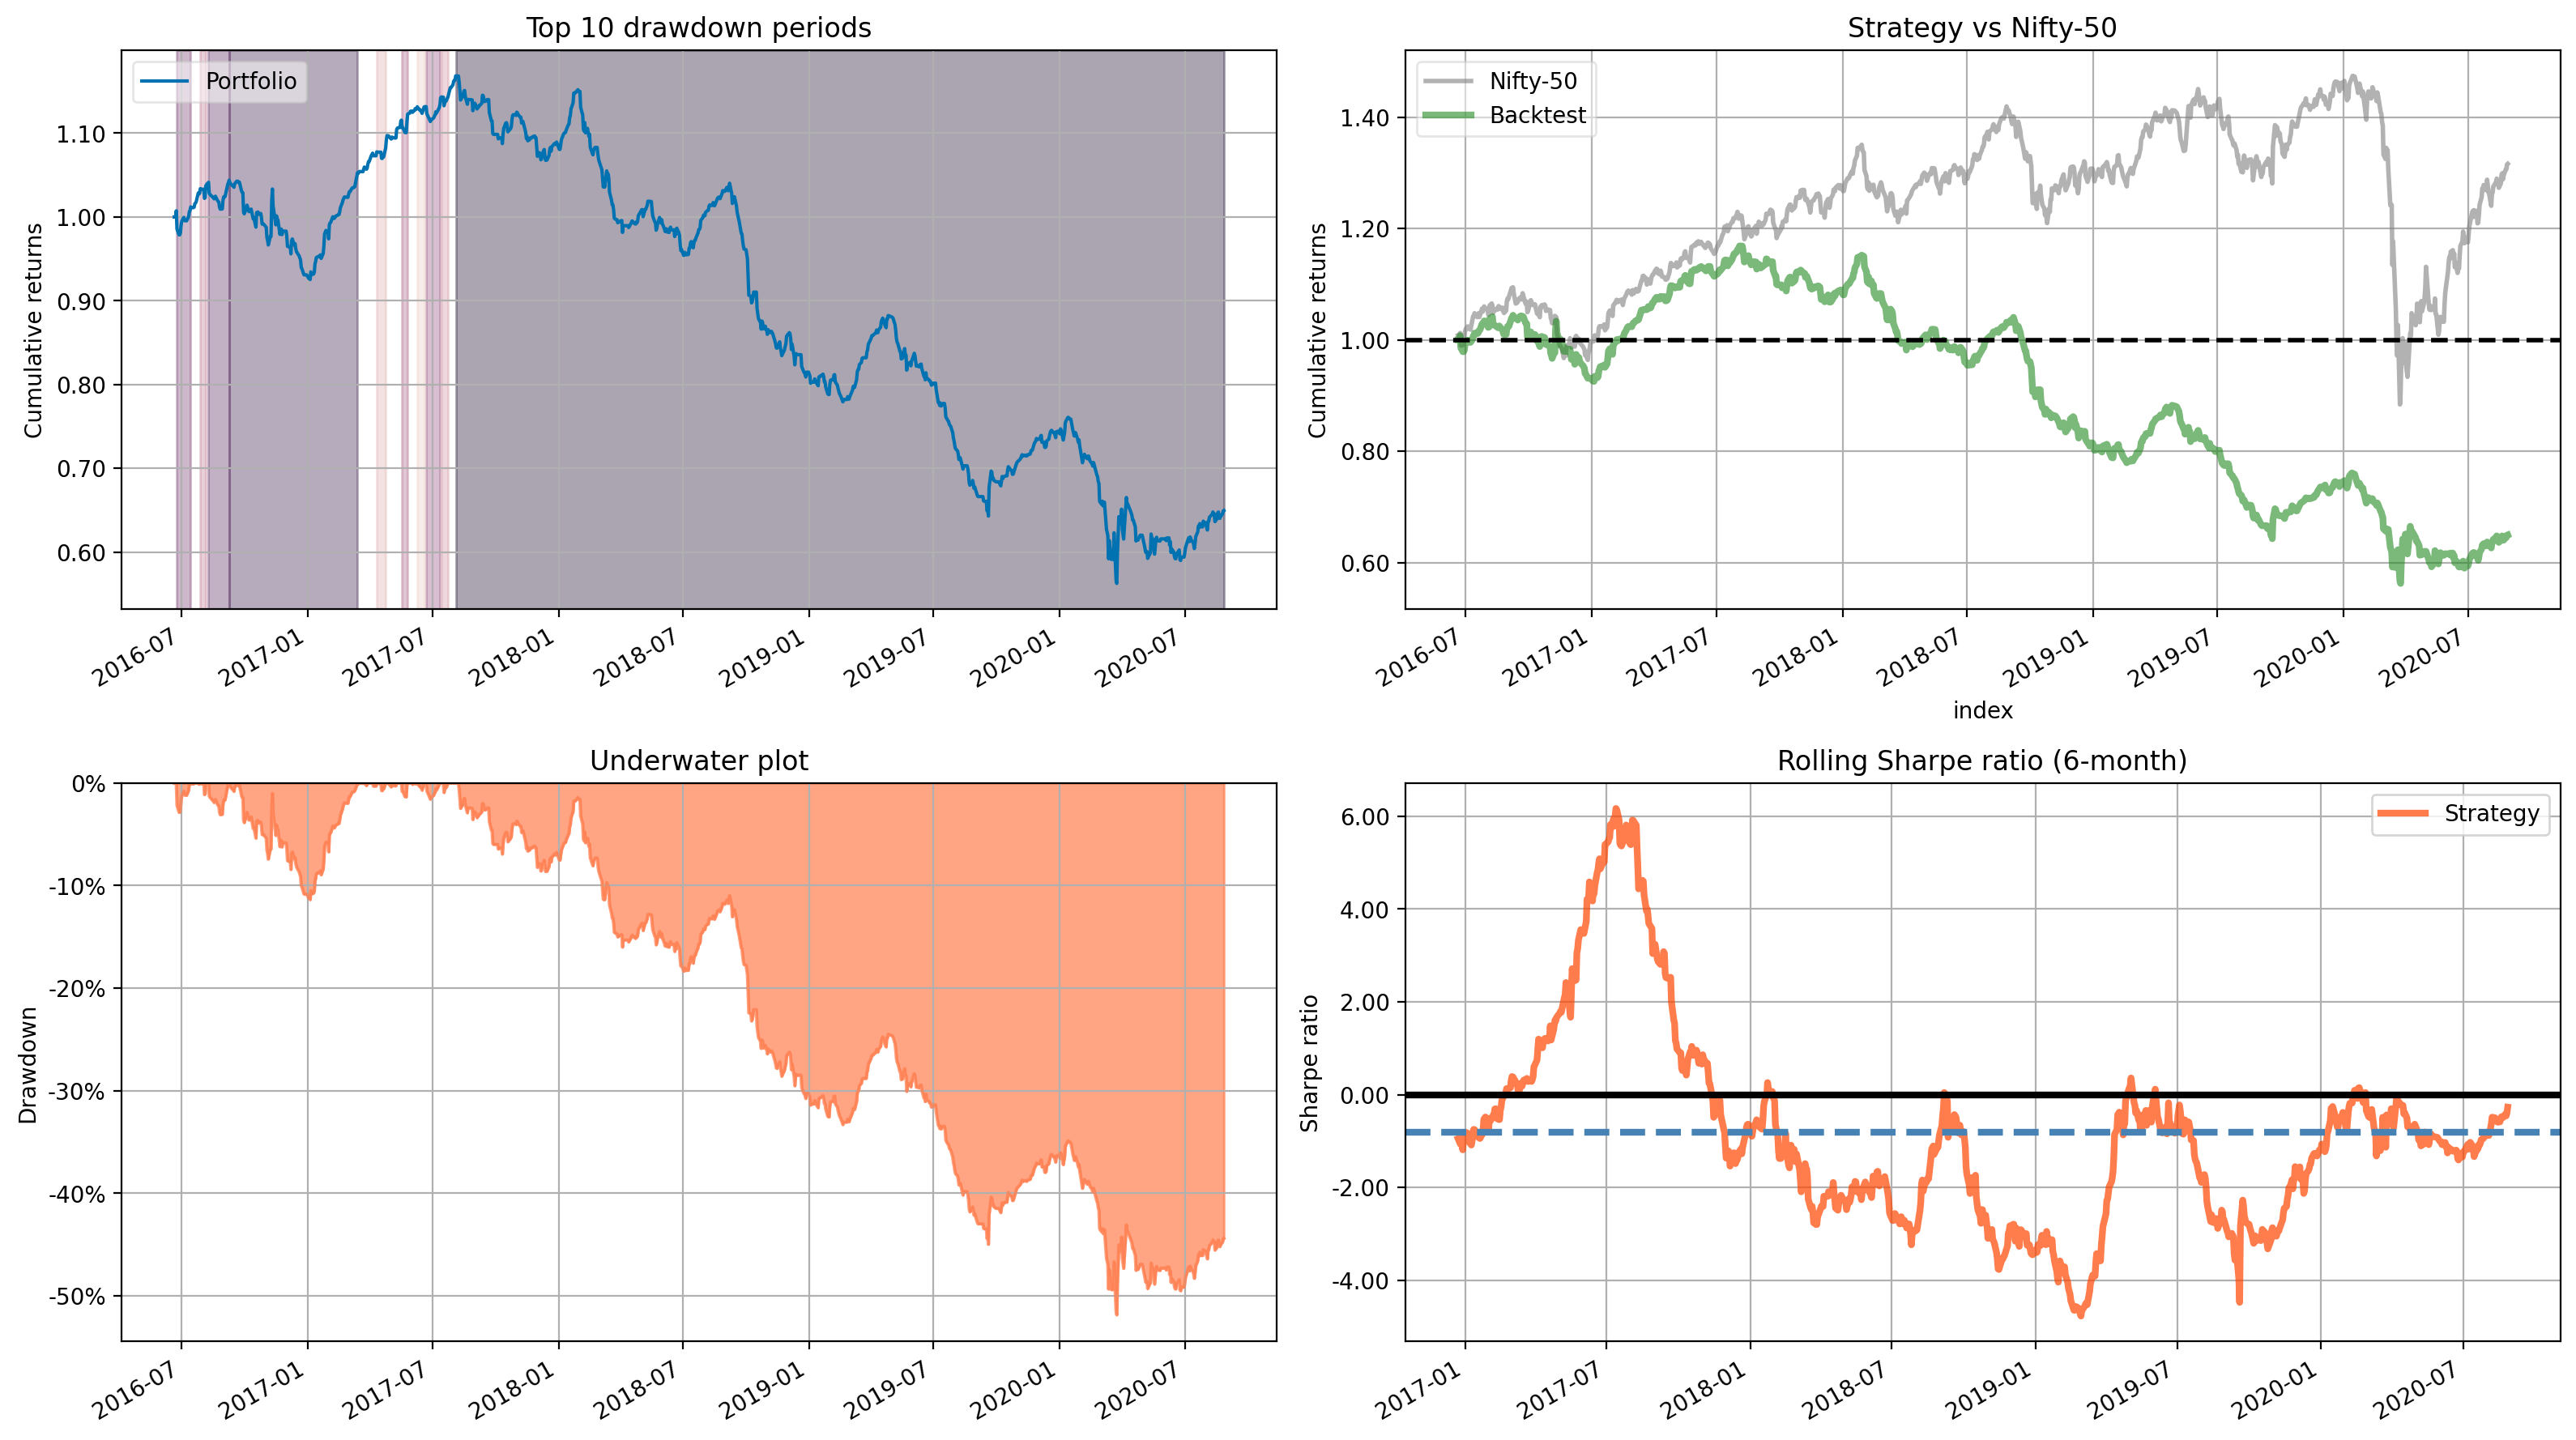

In [49]:
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()

pf.plot_drawdown_periods(returns=returns, ax=axes[0])
axes[0].grid(True)
pf.plot_rolling_returns(returns=returns,
                        factor_returns=benchmark_rets,
                        ax=axes[1], title='Strategy vs Nifty-50')
axes[1].grid(True)
pf.plot_drawdown_underwater(returns=returns, ax=axes[2])
axes[2].grid(True)
pf.plot_rolling_sharpe(returns=returns, ax=axes[3])
axes[3].grid(True)
# fig.suptitle('XXX', fontsize=16, y=0.990)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('images/chart3', dpi=300)

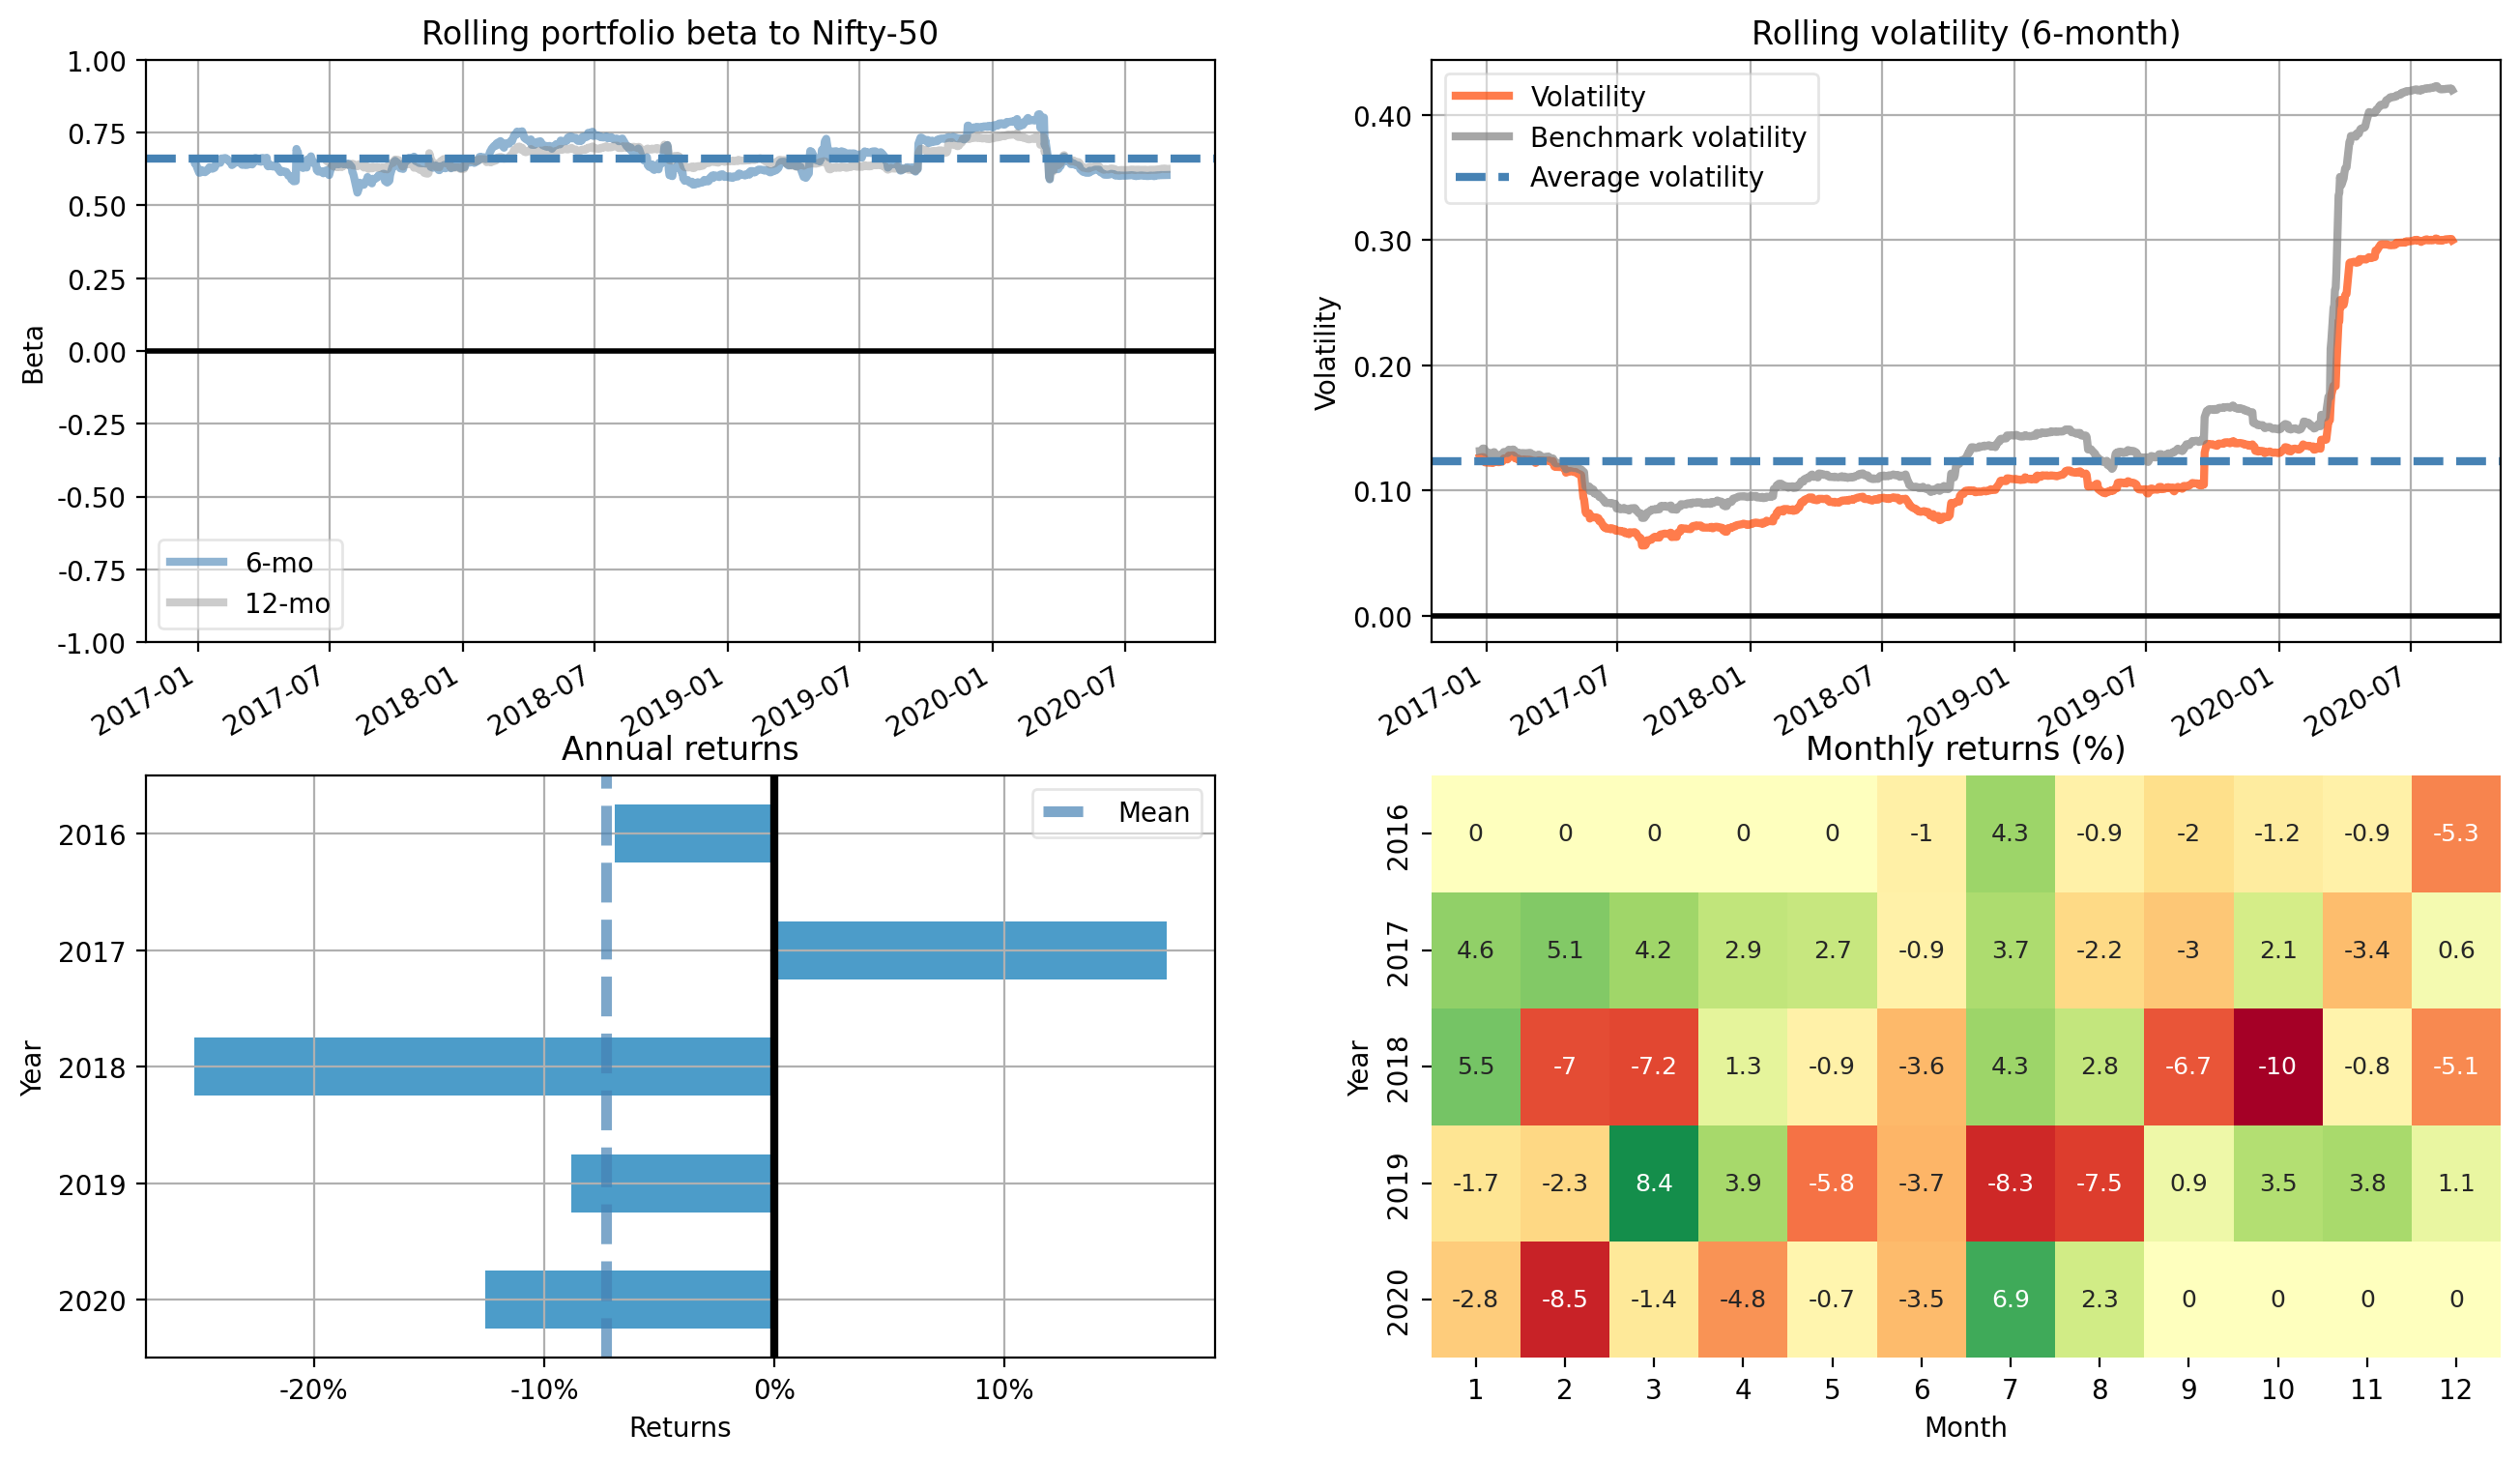

In [50]:
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()

pf.plot_rolling_beta(returns=returns, factor_returns=benchmark_rets, ax=axes[0])
axes[0].grid(True)

pf.plot_rolling_volatility(returns=returns, factor_returns=benchmark_rets,ax=axes[1])
axes[1].grid(True)

pf.plot_annual_returns(returns=returns, ax=axes[2])
axes[2].grid(True)

pf.plot_monthly_returns_heatmap(returns=returns, ax=axes[3],)
# fig.suptitle('XXX', fontsize=16, y=1.0)


plt.tight_layout()
plt.savefig('images/chart4', dpi=300)